In [40]:
# Imported Libraries
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

ModuleNotFoundError: No module named 'imblearn'

In [7]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

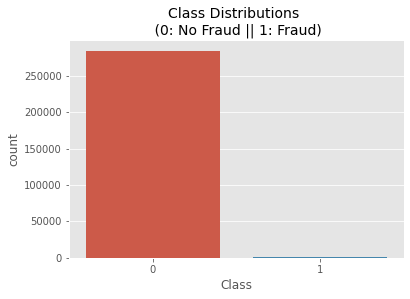

In [9]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

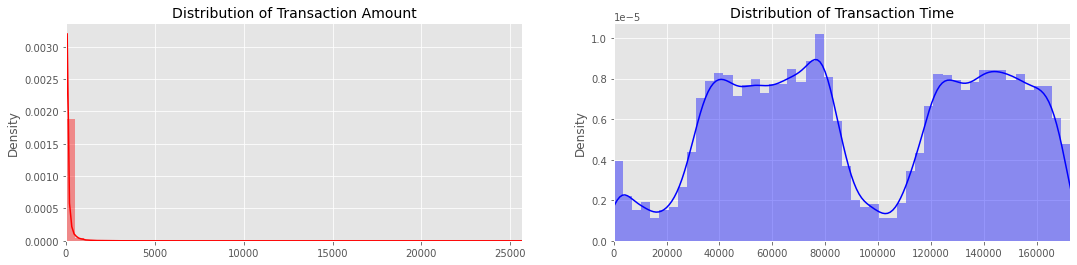

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [12]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [16]:
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
31462,-0.238664,-0.567605,-0.984680,1.063530,1.247120,-0.067992,0.899707,-1.336937,0.989846,-0.121475,...,0.024190,0.009456,-0.059196,-0.247367,0.523379,0.446667,0.300634,-0.004900,0.089079,0
10630,10.401174,-0.785418,-5.187878,6.967709,-13.510931,8.617895,-11.214422,0.672248,-9.462533,5.328704,...,-0.623737,2.086083,0.760190,0.716806,-0.646743,-1.617043,0.172347,0.626647,-0.169726,1
216205,0.656746,0.654272,0.152871,-0.443881,0.491094,-1.883131,-0.006171,-0.492830,0.392772,-0.292055,...,0.218592,0.352442,1.031532,0.209234,0.737304,-1.167852,-0.453702,0.069483,0.051294,0
156990,2.293440,0.289078,-1.000611,3.346850,-5.534491,6.835802,-0.299803,0.095951,-2.440419,1.286301,...,1.189814,0.439757,-0.694099,0.299660,-0.657601,0.101648,0.430457,0.824685,0.326952,1
151730,-0.042479,0.134435,-1.952933,3.541385,-1.310561,5.955664,-1.003993,0.983049,-4.587235,-4.892184,...,1.965030,-1.998091,1.133706,-0.041461,-0.215379,-0.865599,0.212545,0.532897,0.357892,1


Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


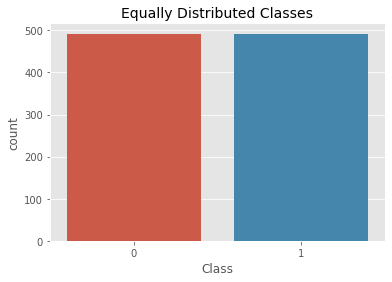

In [18]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))
sns.countplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

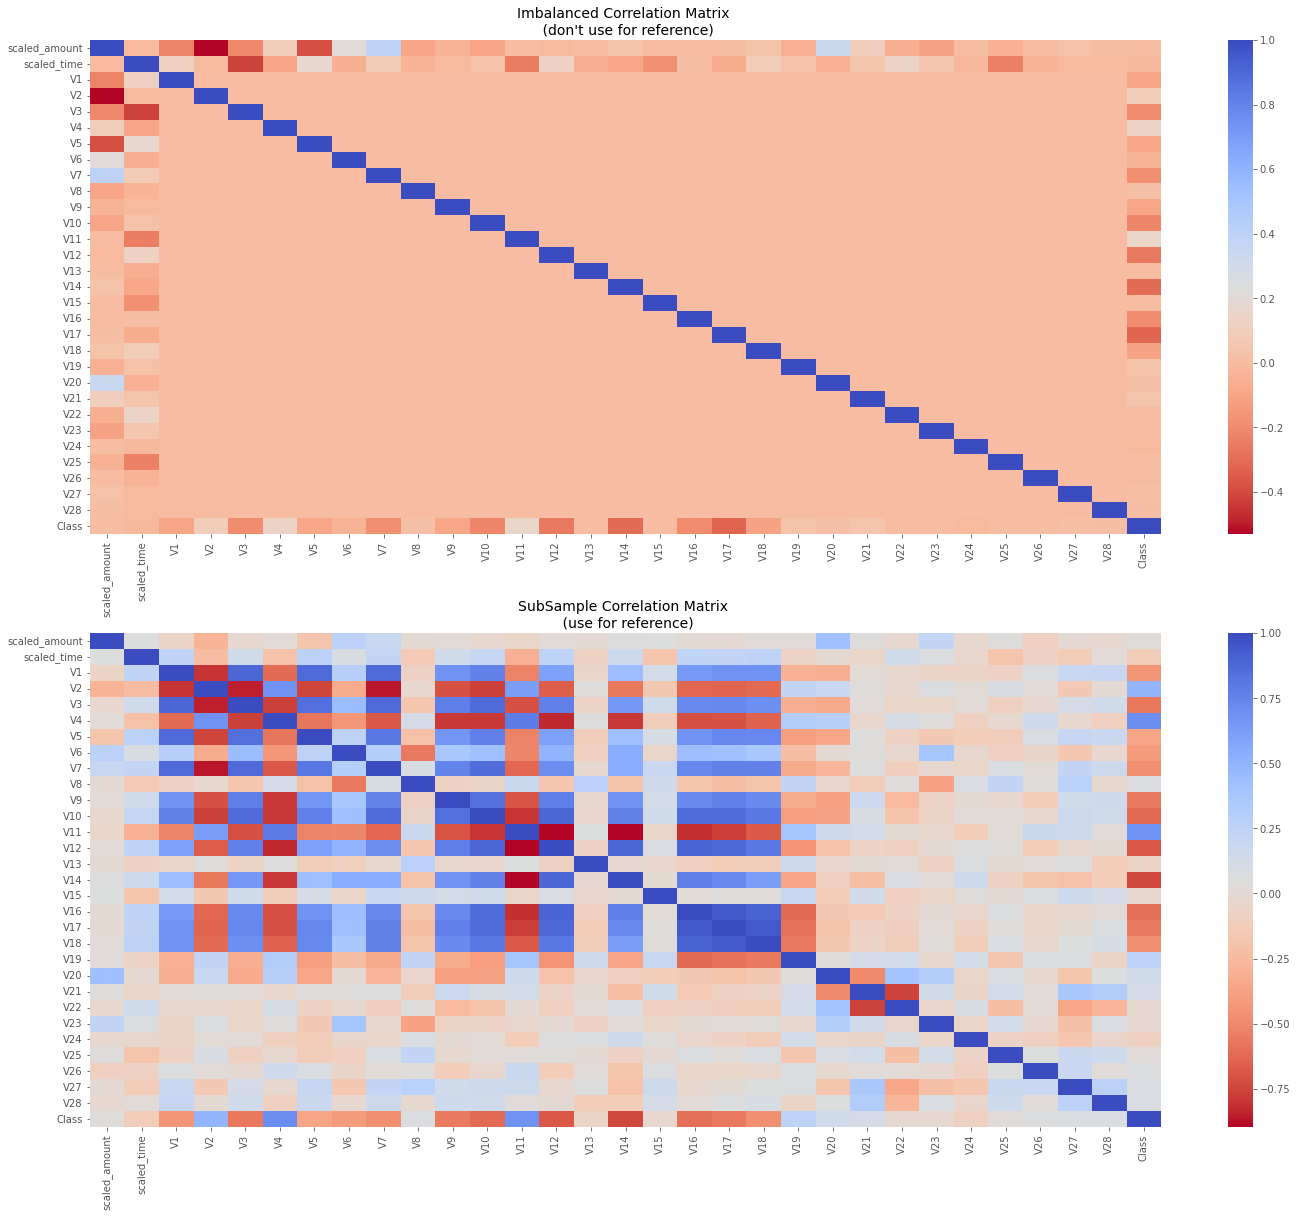

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [22]:
df.shape, new_df.shape

((284807, 31), (984, 31))

In [27]:
new_df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
31462,-0.238664,-0.567605,-0.984680,1.063530,1.247120,-0.067992,0.899707,-1.336937,0.989846,-0.121475,...,0.024190,0.009456,-0.059196,-0.247367,0.523379,0.446667,0.300634,-0.004900,0.089079,0
10630,10.401174,-0.785418,-5.187878,6.967709,-13.510931,8.617895,-11.214422,0.672248,-9.462533,5.328704,...,-0.623737,2.086083,0.760190,0.716806,-0.646743,-1.617043,0.172347,0.626647,-0.169726,1
216205,0.656746,0.654272,0.152871,-0.443881,0.491094,-1.883131,-0.006171,-0.492830,0.392772,-0.292055,...,0.218592,0.352442,1.031532,0.209234,0.737304,-1.167852,-0.453702,0.069483,0.051294,0
156990,2.293440,0.289078,-1.000611,3.346850,-5.534491,6.835802,-0.299803,0.095951,-2.440419,1.286301,...,1.189814,0.439757,-0.694099,0.299660,-0.657601,0.101648,0.430457,0.824685,0.326952,1
151730,-0.042479,0.134435,-1.952933,3.541385,-1.310561,5.955664,-1.003993,0.983049,-4.587235,-4.892184,...,1.965030,-1.998091,1.133706,-0.041461,-0.215379,-0.865599,0.212545,0.532897,0.357892,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,-0.307413,-0.852912,-4.696795,2.693867,-4.475133,5.467685,-1.556758,-1.549420,-4.104215,0.553934,...,-0.158971,0.573898,-0.080163,0.318408,-0.245862,0.338238,0.032271,-1.508458,0.608075,1
11343,-0.293440,-0.762814,-14.179165,7.421370,-21.405836,11.927512,-7.974281,-2.202710,-15.471612,-0.356595,...,1.002764,-2.366836,1.130955,0.991153,-1.033132,-0.327179,0.634693,2.171905,-1.395288,1
228255,-0.223294,0.713472,-0.671464,1.732891,0.620739,4.297292,0.931067,0.493711,0.327910,0.507683,...,0.341361,-0.173555,-0.652727,0.051939,0.526361,-0.443321,0.073143,0.284760,0.119154,0
190368,2.150493,0.518227,-2.272473,2.935226,-4.871394,2.419012,-1.513022,-0.480625,-2.126136,1.883507,...,-0.031085,0.718504,0.893850,-0.031632,0.322913,-0.058406,-0.411649,0.573803,0.176067,1


In [31]:
x = new_df.iloc[:, :30].to_numpy()
y = new_df.Class.to_numpy()
new_df.to_numpy().shape, x.shape, y.shape

((984, 31), (984, 30), (984,))

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1, shuffle = True)
X_train = x_train.copy()
X_test = x_test.copy()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((787, 30), (197, 30), (787,), (197,))

In [35]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [38]:
from sklearn.svm import LinearSVC

model = LinearSVC(loss='hinge', dual=True)
model.fit(X_train, y_train)

print_score(model, X_train, y_train, X_test, y_test, train=True)
print_score(model, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 96.19%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.941889    0.983957  0.961881    0.962923      0.962843
recall       0.984810    0.938776  0.961881    0.961793      0.961881
f1-score     0.962871    0.960836  0.961881    0.961853      0.961857
support    395.000000  392.000000  0.961881  787.000000    787.000000
_______________________________________________
Confusion Matrix: 
 [[389   6]
 [ 24 368]]

Test Result:
Accuracy Score: 91.37%
_______________________________________________
CLASSIFICATION REPORT:
                   0           1  accuracy   macro avg  weighted avg
precision   0.863636    0.977011  0.913706    0.920324      0.921187
recall      0.979381    0.850000  0.913706    0.914691      0.913706
f1-score    0.917874    0.909091  0.913706    0.913483      0.913416
support    97.000000  100.000000  0.913706  197.000000    197.00000

In [42]:
model = SVC(kernel='rbf', gamma=0.5, C=0.1)
model.fit(X_train, y_train)

print_score(model, X_train, y_train, X_test, y_test, train=True)
print_score(model, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 50.19%
_______________________________________________
CLASSIFICATION REPORT:
                    0      1  accuracy   macro avg  weighted avg
precision    0.501906    0.0  0.501906    0.250953      0.251910
recall       1.000000    0.0  0.501906    0.500000      0.501906
f1-score     0.668359    0.0  0.501906    0.334179      0.335453
support    395.000000  392.0  0.501906  787.000000    787.000000
_______________________________________________
Confusion Matrix: 
 [[395   0]
 [392   0]]

Test Result:
Accuracy Score: 49.24%
_______________________________________________
CLASSIFICATION REPORT:
                   0      1  accuracy   macro avg  weighted avg
precision   0.492386    0.0  0.492386    0.246193      0.242444
recall      1.000000    0.0  0.492386    0.500000      0.492386
f1-score    0.659864    0.0  0.492386    0.329932      0.324908
support    97.000000  100.0  0.492386  197.000000    197.000000
_______________________________________________


In [44]:
svc = SVC()
param = {
    'C': [0.1,0.8,0.9,1,1.1,1.2,1.3,1.4],
    'kernel':['linear', 'rbf'],
    'gamma' :[0.1,0.8,0.9,1,1.1,1.2,1.3,1.4]
}
grid_svc = GridSearchCV(svc, param_grid=param, scoring='accuracy', cv=10, )
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'gamma': [0.1, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [47]:
gs_bp = grid_svc.best_params_
grid_svc.best_params_

{'C': 0.8, 'gamma': 0.1, 'kernel': 'linear'}

In [48]:
svc2 = SVC(C = gs_bp['C'], gamma =  gs_bp['gamma'], kernel= gs_bp['kernel'])
svc2.fit(X_train, y_train)
pred_svc2 = svc2.predict(X_test)
print(classification_report(y_test, pred_svc2))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92        97
           1       0.98      0.85      0.91       100

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197

